In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [17]:
fifa = pd.read_csv('fifa21_train.csv')

In [3]:
#Change to lowercase
cols = []
for colname in fifa.columns:
    cols.append(colname.lower())
fifa.columns = cols
cols
#display(file.head())
fifa.shape

(11701, 101)

In [4]:
pd.set_option('display.max_columns', None) 
fifa.head(60)

fifa.sort_values(by=['ova'], axis = 0, ascending = False)

,id,name,age,nationality,club,bp,position,team & contract,height,weight,foot,growth,joined,loan date end,value,wage,release clause,contract,attacking,crossing,finishing,heading accuracy,short passing,volleys,skill,dribbling,curve,fk accuracy,long passing,ball control,movement,acceleration,sprint speed,agility,reactions,balance,power,shot power,jumping,stamina,strength,long shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing tackle,sliding tackle,goalkeeping,gk diving,gk handling,gk kicking,gk positioning,gk reflexes,total stats,base stats,w/f,sm,a/w,d/w,ir,pac,sho,pas,dri,def,phy,hits,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,ova
5291,158023,L. Messi,33,Argentina,FC Barcelona,RW,RW ST CF,FC Barcelona 2004 ~ 2021,"5'7""",159lbs,Left,0,"Jul 1, 2004",NaN,€67.5M,€560K,€138.4M,2004 ~ 2021,429,85,95,70,91,88.0,470,96,93.0,94,91,96,451,91,80,91.0,94,95.0,389,86,68.0,72,69,94,347,44,40.0,93.0,95.0,75,96.0,91,32,35,24.0,54,6,11,15,14,8,2231,466,4 ★,4★,Medium,Low,5 ★,85,92,91,95,38,65,830,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3,19+3,93
8048,20801,Cristiano Ronaldo,35,Portugal,Juventus,ST,ST LW,Juventus 2018 ~ 2022,"6'2""",183lbs,Right,0,"Jul 10, 2018",NaN,€46M,€220K,€75.9M,2018 ~ 2022,437,84,95,90,82,86.0,414,88,81.0,76,77,92,431,87,91,87.0,95,71.0,444,94,95.0,84,78,93,353,63,29.0,95.0,82.0,84,95.0,84,28,32,24.0,58,7,11,15,14,11,2221,464,4 ★,5★,High,Low,5 ★,89,93,81,89,35,77,750,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3,20+3,92
2219,188545,R. Lewandowski,31,Poland,FC Bayern München,ST,ST,FC Bayern München 2014 ~ 2023,"6'0""",176lbs,Right,0,"Jul 1, 2014",NaN,€80M,€240K,€132M,2014 ~ 2023,423,71,94,85,84,89.0,407,85,79.0,85,70,88,407,77,78,77.0,93,82.0,420,89,84.0,76,86,85,391,81,49.0,94.0,79.0,88,88.0,96,35,42,19.0,51,15,6,12,8,10,2195,457,4 ★,4★,High,Medium,4 ★,78,91,78,85,43,82,487,89+2,89+2,89+2,85+0,87+0,87+0,87+0,85+0,85+3,85+3,85+3,83+3,79+3,79+3,79+3,83+3,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,91
4782,190871,Neymar Jr,28,Brazil,Paris Saint-Germain,LW,LW CAM,Paris Saint-Germain 2017 ~ 2022,"5'9""",150lbs,Right,0,"Aug 3, 2017",NaN,€90M,€270K,€166.5M,2017 ~ 2022,408,85,87,62,87,87.0,448,95,88.0,89,81,95,453,94,89,96.0,91,83.0,357,80,62.0,81,50,84,356,51,36.0,87.0,90.0,92,93.0,94,35,30,29.0,59,9,9,15,15,11,2175,451,5 ★,5★,High,Medium,5 ★,91,85,86,94,36,59,546,84+3,84+3,84+3,90+0,89+0,89+0,89+0,90+0,90+1,90+1,90+1,90+1,83+3,83+3,83+3,90+1,67+3,62+3,62+3,62+3,67+3,62+3,49+3,49+3,49+3,62+3,20+3,91
9219,192985,K. De Bruyne,29,Belgium,Manchester City,CAM,CAM CM,Manchester City 2015 ~ 2023,"5'11""",154lbs,Right,0,"Aug 30, 2015",NaN,€87M,€370K,€161M,2015 ~ 2023,407,94,82,55,94,82.0,441,88,85.0,83,93,92,398,77,76,78.0,91,76.0,408,91,63.0,89,74,91,408,76,66.0,88.0,94.0,84,91.0,186,68,65,53.0,56,15,13,5,10,13,2304,485,5 ★,4★,High,High,4 ★,76,86,93,88,64,78,406,83+3,83+3,83+3,88+0,88+0,88+0,88+0,88+0,89+2,89+2,89+2,89+2,89+2,89+2,89+2,89+2,79+3,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8049,252520,Zhou Xiao,21,China PR,Dalian YiFang FC,LB,CB LB,Dalian YiFang FC 2019 ~ 2023,"6'2""",165lbs,Left,10,"Jul 29, 2019",NaN,€45K,€2K,€79K,2019 ~ 2023,163,40,18,40,45,20.0,171,40,33.0,20,40,38,279,60,63,57.0,47,52.0,231,37,66.0,60,55,13,185,45,47.0,33.0,33.0,27,33.0,136,45,46,45.0,50,10,11,7,10,12,1215,265,3 ★,2★,Medium,Medium,1 ★,62,22,39,42,45,55,3,37+

In [5]:
#Check the NaN values
#see loan date has a lot 1172, position has 288, composure has 279,
#joined,volleys,curve,agility,balance,jumping,vision,sliding tackle all have 41
#a/w and d/w both have 59
#club has 41
#interceptions and positioning have 7
nan = []
for col in fifa.columns:
    if fifa[col].isna().sum() != 0:
        print(col, fifa[col].isna().sum())

club 18
position 288
joined 41
loan date end 11072
volleys 41
curve 41
agility 41
balance 41
jumping 41
interceptions 7
positioning 7
vision 41
composure 279
sliding tackle 41
a/w 59
d/w 59


In [6]:
print(fifa.columns)

Index(['id', 'name', 'age', 'nationality', 'club', 'bp', 'position',
       'team & contract', 'height', 'weight',
       ...
       'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'ova'],
      dtype='object', length=101)


In [7]:
#Wrangle the data
fifa.columns = list(map(lambda x: x.lower(), fifa.columns))
fifa = fifa.drop('loan date end', axis = 1)
fifa["club"] = fifa["club"].fillna("free agent")

first_day = datetime.date(2020,9,1)  
first_day.strftime('%b %d,%Y')
fifa['joined'] = fifa['joined'].fillna(first_day.strftime('%b %d,%Y'))

fifa['wage'] = (pd.to_numeric(fifa['wage'].str.strip('K').str.strip('€')))* 1000 #convert wage to millions
fifa['weight']=pd.to_numeric(fifa['weight'].str.strip('lbs'))  #take out lbs from weight
fifa = fifa.dropna()

fifa = fifa.drop(['id','name','nationality','attacking', 'position', 'crossing', 'finishing','goalkeeping',
       'heading accuracy', 'short passing', 'skill', 'dribbling','club',
       'fk accuracy', 'long passing', 'ball control', 'movement',
       'acceleration', 'sprint speed', 'agility', 'reactions', 'balance',
       'power', 'shot power', 'jumping', 'stamina', 'strength', 'long shots',
       'mentality', 'aggression', 'interceptions', 'positioning', 'vision',
       'penalties', 'defending', 'marking', 'standing tackle',
       'sliding tackle', 'gk diving', 'gk handling',
       'gk kicking', 'gk positioning', 'gk reflexes',
       'pac','sho'], axis = 1)
fifa = fifa.drop(columns=['height','dri','def','phy','ls' ,'st','rs','lw','lf','cf','rf','rw','lam','cam','team & contract',
        'ram','lm','lcm','cm','rcm','rm','lwb','ldm','ir','w/f','sm','value','release clause','bp','foot','contract',
        'cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk','a/w','d/w'])  #dropped more 



In [8]:
fifa.head()

,age,weight,growth,joined,wage,volleys,curve,composure,total stats,base stats,pas,hits,ova
0,26,161,1,"Jul 1, 2015",4000,44.0,44.0,54.0,1682,357,63,3,64
1,30,159,0,"Jan 16, 2015",23000,76.0,78.0,70.0,1961,412,68,44,77
2,33,134,0,"Jan 31, 2019",49000,75.0,89.0,82.0,1925,404,78,73,80
3,22,152,13,"Jul 1, 2016",4000,36.0,41.0,48.0,1527,329,54,7,59
4,23,150,8,"Jul 1, 2018",2000,34.0,44.0,58.0,1664,360,60,4,65


In [9]:
#Make a cleaning function
def fifa_clean(df):
    df.columns = list(map(lambda x: x.lower(), df.columns))
    df = df.drop('loan date end', axis = 1)
    df["club"] = df["club"].fillna("free agent")
    first_day = datetime.date(2020,9,1)  
    first_day.strftime('%b %d,%Y')
    df['joined'] = df['joined'].fillna(first_day.strftime('%b %d,%Y'))
    df['wage'] = (pd.to_numeric(df['wage'].str.strip('K').str.strip('€')))* 1000 #convert wage to millions
    df['weight']=pd.to_numeric(df['weight'].str.strip('lbs'))  #take out lbs from weight
    df = df.dropna()
    df = df.drop(['id','name','nationality','attacking', 'position', 'crossing', 'finishing','goalkeeping',
       'heading accuracy', 'short passing', 'skill', 'dribbling','club',
       'fk accuracy', 'long passing', 'ball control', 'movement',
       'acceleration', 'sprint speed', 'agility', 'reactions', 'balance',
       'power', 'shot power', 'jumping', 'stamina', 'strength', 'long shots',
       'mentality', 'aggression', 'interceptions', 'positioning', 'vision',
       'penalties', 'defending', 'marking', 'standing tackle',
       'sliding tackle', 'gk diving', 'gk handling',
       'gk kicking', 'gk positioning', 'gk reflexes',
       'pac','sho'], axis = 1)
    df = df.drop(columns=['height','dri','def','phy','ls' ,'st','rs','lw','lf','cf','rf','rw','lam','cam','team & contract',
        'ram','lm','lcm','cm','rcm','rm','lwb','ldm','ir','w/f','sm','value','release clause','bp','foot','contract',
        'cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk','a/w','d/w'])  #dropped more 
    return df

In [10]:
df = pd.read_csv('fifa21_train.csv')
fifa_clean(df)

,age,weight,growth,joined,wage,volleys,curve,composure,total stats,base stats,pas,hits,ova
0,26,161,1,"Jul 1, 2015",4000,44.0,44.0,54.0,1682,357,63,3,64
1,30,159,0,"Jan 16, 2015",23000,76.0,78.0,70.0,1961,412,68,44,77
2,33,134,0,"Jan 31, 2019",49000,75.0,89.0,82.0,1925,404,78,73,80
3,22,152,13,"Jul 1, 2016",4000,36.0,41.0,48.0,1527,329,54,7,59
4,23,150,8,"Jul 1, 2018",2000,34.0,44.0,58.0,1664,360,60,4,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11695,29,154,0,"Jul 1, 2019",500000,60.0,56.0,60.0,1638,337,47,4,65
11696,25,168,5,"Feb 8, 2018",3000,28.0,49.0,46.0,1589,347,56,3,65
11697,27,174,4,"Jul 1, 2019",4000,16.0,15.0,56.0,1123,387,66,3,70
11698,22,143,8,"Jan 23, 2019",2000,41.0,57.0,58.0,1603,337,60,6,67


In [11]:
#Create categorical and numerical columns
numerical = fifa.select_dtypes(include='number')
categorical = fifa.select_dtypes(include='object')
categorical

,joined,hits
0,"Jul 1, 2015",3
1,"Jan 16, 2015",44
2,"Jan 31, 2019",73
3,"Jul 1, 2016",7
4,"Jul 1, 2018",4
...,...,...
11695,"Jul 1, 2019",4
11696,"Feb 8, 2018",3
11697,"Jul 1, 2019",3
11698,"Jan 23, 2019",6


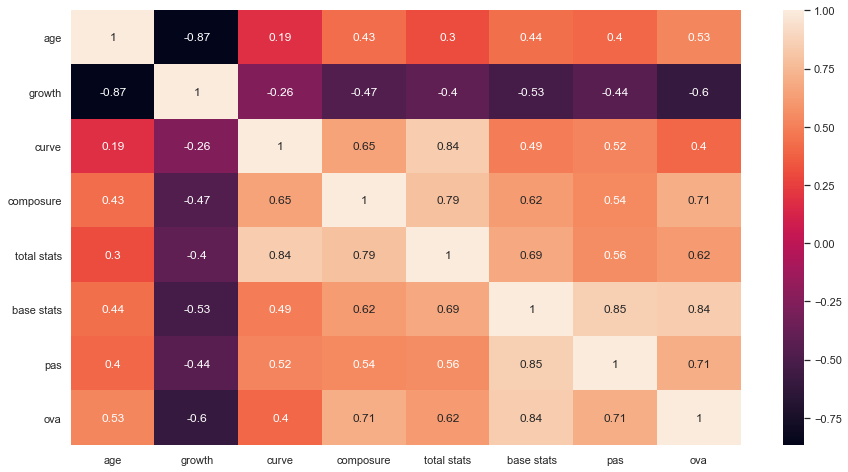

In [12]:
#Explore the numerical data

numerical.shape # 53 numerical columns

#correlations
cf = 0.4
columns = []
corr_matrix = numerical.corr()                 #this code is from Arek!

for col in numerical.columns:
        if abs(corr_matrix.loc[col,'ova']) >= cf:
            columns.append(col)

numerical_trimmed = pd.DataFrame(numerical, columns=columns)
numerical_trimmed

corr_matrix2 = numerical_trimmed.corr()
sns.set(rc={'figure.figsize':(15,8)})
sns.heatmap(corr_matrix2, annot=True)
plt.show()

In [13]:
#6 Normalizing 

y = fifa['ova']   
X = fifa.drop('ova', axis = 1)

X_num = X.select_dtypes(include='number')
X_cat = X.select_dtypes(include='object')

# MinMax Scaler
Scaler = MinMaxScaler().fit(X_num)
X_normalized = Scaler.transform(X_num)
X_normalized = pd.DataFrame(X_normalized,columns=X_num.columns)
X_num_final = X_normalized

display(X.shape)
display(y.shape)

(11222, 12)

(11222,)

In [14]:
#Concatenating
X = pd.concat([X_num_final, X_cat], axis = 1) 

In [15]:
X.shape

(11686, 12)

In [16]:
#Model

#Test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 33)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

ValueError: Found input variables with inconsistent numbers of samples: [11686, 11222]

In [ ]:
#Fitting 
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train) # fitting the model with train

In [ ]:
#Results
#R2
predictions_train = lm.predict(X_train)
r2_train = r2_score(y_train, predictions_train)
print("R2 Train:",round(r2_train,2)) 
predictions_test = lm.predict(X_test)
r2_test = r2_score(y_test, predictions_test)
r2_test
print('R2 Test:',round(r2_test,2))
#MSE
MSE = mean_squared_error(y_test,predictions_test)
print('MSE:',round(MSE,1))
#RMSE
RMSE = np.sqrt(mean_squared_error(y_test,predictions_test))
print('RMSE:',round(RMSE,1))
#MAE
MAE = mean_absolute_error(y_test, predictions_test)
print('MAE:',round(MAE,1))

In [ ]:
#Validation

import warnings                     #this is Areks code!
warnings.filterwarnings("ignore")

#Reading new data and running clean function
df = pd.read_csv('fifa21_validate.csv')
fifa_clean(df)
cleandf 

#Categorical and numerical columns
numerical = cleandf.select_dtypes(include='number')
categorical = cleandf.select_dtypes(include='object')

#Scaling & splitting
y = cleandf[['ova']]
X = cleandf.drop('ova', axis = 1)
X_num = X.select_dtypes(include='number')
X_cat = X.select_dtypes(include='object')
X_normalized = Scaler.transform(X_num)
X_normalized = pd.DataFrame(X_normalized,columns=X_num.columns)
X_num_final = X_normalized

#Concatting 
X = pd.concat([X_num_final, X_cat], axis = 1)

#Results on validation data

# R2
predictions= lm.predict(X)
r2_test = r2_score(y, predictions)
print('R2 Test:',round(r2_test,2))
# MSE
MSE = mean_squared_error(y,predictions)
print('MSE:',round(MSE,1))
# RMSE
RMSE = np.sqrt(mean_squared_error(y,predictions))
print('RMSE:',round(RMSE,1))
# MAE
MAE = mean_absolute_error(y, predictions)
print('MAE:',round(MAE,1))